In [1]:
import numpy as np
import xarray as xr
import os
import sys
sys.path.append("../")
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.data_utils import *        
from src.vae_model import *
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = "../data/"
batch_size = 32
chl_data = torch.load(data_dir + "chl_dataset_2016_2022.pt")
train_loader, test_loader = get_data_loaders(chl_data, 0.8, batch_size=batch_size)

/tmp/ipykernel_16675/707057254.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chl_data = torch.load(data_dir + "chl_dataset_2016_2022.pt")


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
torch.cuda.empty_cache()
from src.vae_model import *

log_dir = "../runs/vae"  # for tensorboard
model = ConvVAE(input_channels=10, latent_dim=40).to(device)
opt = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10, verbose=True)

kl_lambda = 1.5

/gscratch/rao/aresf/miniconda3/envs/torch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training epoch 1:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 25/200: Train loss: 126383.6299 | 28.8244, Val loss: 160204.6632


Epoch 50/200: Train loss: 109529.5558 | 36.9344, Val loss: 136228.2313


Epoch 75/200: Train loss: 102529.8615 | 43.4003, Val loss: 125658.2651


Epoch 100/200: Train loss: 99247.1809 | 49.1677, Val loss: 119591.5675


Epoch 125/200: Train loss: 96618.8301 | 56.5199, Val loss: 115329.3458


Epoch 150/200: Train loss: 94544.1733 | 63.2956, Val loss: 112065.8450


Epoch 175/200: Train loss: 91209.4337 | 71.0849, Val loss: 109363.5629


Epoch 200/200: Train loss: 89068.9690 | 71.3884, Val loss: 106914.4624


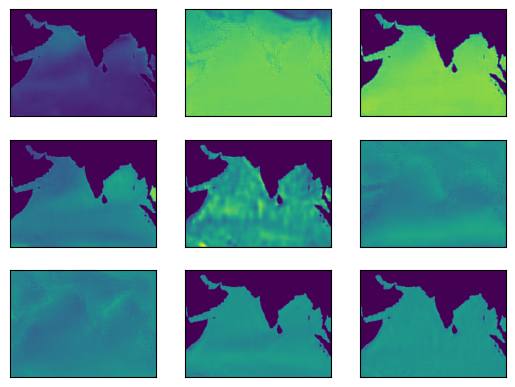

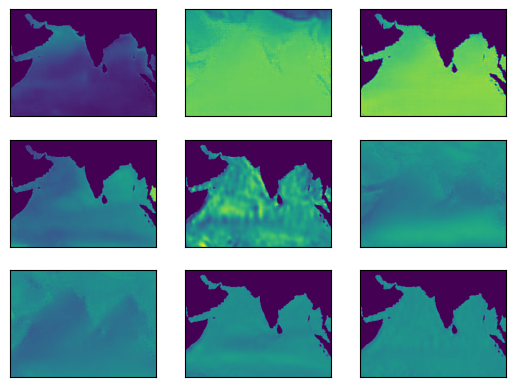

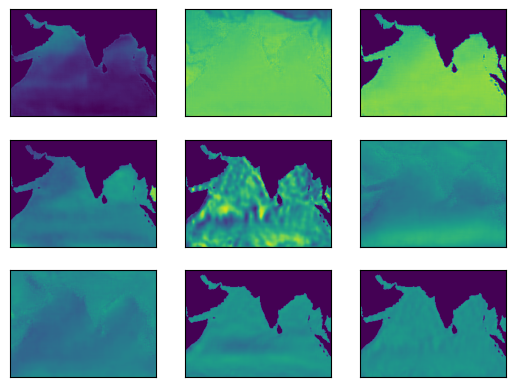

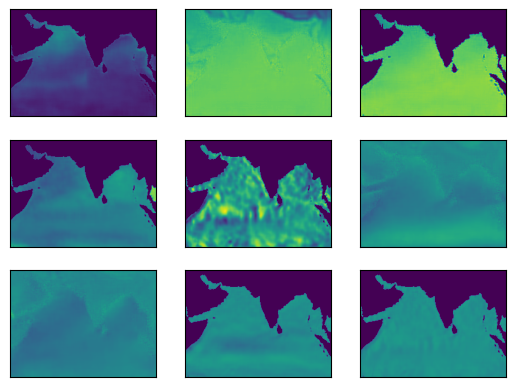

In [9]:
num_epochs = 200
train_rec_losses, train_kl_losses, val_losses = train(
    model,
    opt,
    train_loader,
    test_loader,
    device,
    kl_lambda=kl_lambda,
    num_epochs=num_epochs,
    show_every=25,
    plot_every=50,
    scheduler=scheduler,
    checkpoint_dir="../saved_models/checkpoints/vae/",
    checkpoint_patience=25,
    log_dir=None,
)

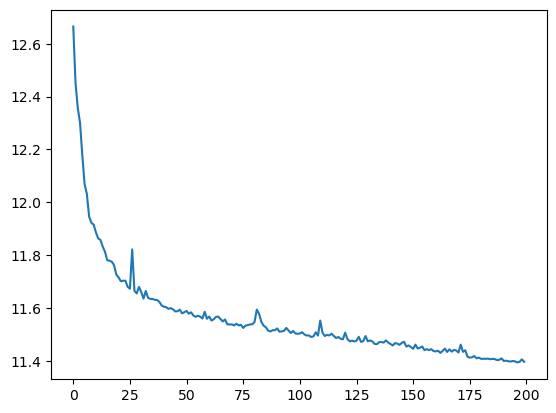

In [15]:
plt.plot(np.log(val_losses))

In [10]:
x, y = next(iter(test_loader))
xy = torch.cat((x, y.unsqueeze(1)), dim=1)

In [11]:
xhat = get_output(model, x, y, device)

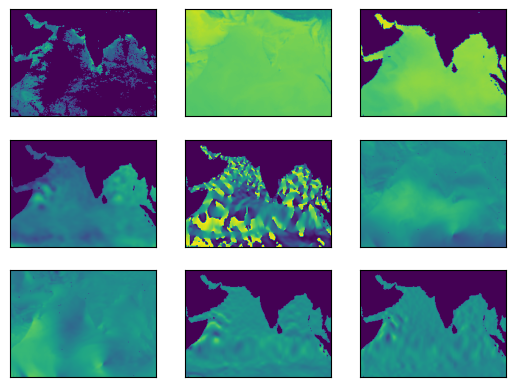

In [12]:
plot_channels(x, batch_ind=0)

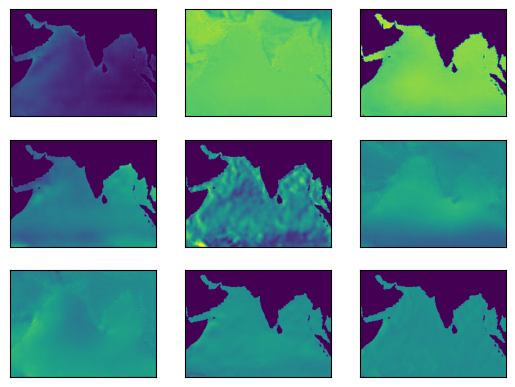

In [13]:
plot_channels(xhat, batch_ind=0)

In [14]:
F.mse_loss(torch.tensor(xhat), xy)

tensor(0.0234)